<a href="https://colab.research.google.com/github/Jia-Wei-Liao/Numerical-PDE/blob/main/Final/DGM_Biharmonic2D_uniform_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jia-Wei, Liao (jw.sc09@nycu.edu.tw)
# Final Project of Numerical Methods for Partial Differential Equations 2021
# training data: 10*10 uniform mesh
# testing data: 100*100 uniform mesh 

In [ ]:
import random, time, csv, os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input

# Set up the Neural Network

In [ ]:
class Residual_block(tf.keras.Model):
  def __init__(self, n_Neural):
    super(Residual_block, self).__init__()
    self.Dense1 = Dense(n_Neural)
    #self.Dense2 = Dense(n_Neural)
  
  def call(self, inputs):
    x = self.Dense1(inputs)
    x = tf.nn.sigmoid(x)
    #x = x*tf.nn.sigmoid(x)
    #x = self.Dense2(x)
    #x = x*tf.nn.sigmoid(x)+x

    return x


class ResNet(tf.keras.Model):
  def __init__(self):
    super(ResNet, self).__init__()
    self.RB1 = Residual_block(10)
    #self.RB2 = Residual_block(10)
    self.FinalLayer1 = Dense(1)
    self.FinalLayer2 = Dense(1)

    self.input_layer = Input(shape=(2))
    self.outputs = self.call(self.input_layer)

    super(ResNet, self).__init__(inputs=self.input_layer, outputs=self.outputs)
    
  def call(self, inputs, training=True):
    x = self.RB1(inputs)
    #x = self.RB2(x)
    y = self.FinalLayer1(x)
    z = self.FinalLayer2(x)

    if training: return y, z
    else: return y

Model: "res_net_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
residual_block_3 (Residual_bloc (None, 10)           30          input_4[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 1)            11          residual_block_3[0][0]           
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 1)            11          residual_block_3[0][0]           
Total params: 52
Trainable params: 52
Non-trainable params: 0
____________________________

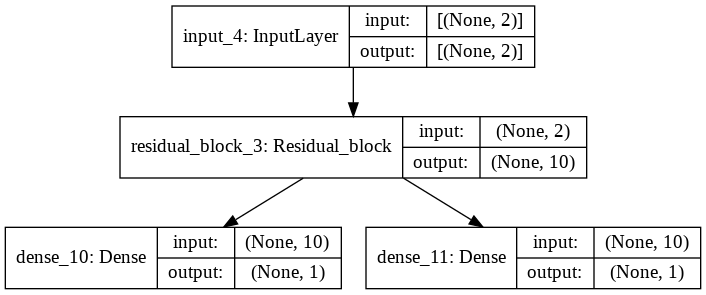

In [ ]:
model = ResNet()
model.build((None, 2))
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# Set the Parameter

In [ ]:
epochs = 50000
alpha = 1
beta = 1
lr = 1e-2
optimizer = tf.keras.optimizers.Adam(lr)
#optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.1)
mse = tf.keras.losses.MeanSquaredError()
N = 64  # number of interior sample point
M = 36  # number of boundary sample point

test_period = 500
save_period = 1000
save_weight = False
save_loss = False
weight_path = 'DGM_Biharmonic2DWeight'

if not os.path.isdir(weight_path):
  os.makedirs(weight_path)

# Define the function and exact solution

In [ ]:
def f(X):
  x, y = X[:, 0], X[:, 1]
  return (np.sin(np.pi*y) - 2*np.pi**2 * np.sin(np.pi*y) + np.pi**4 * np.sin(np.pi*y))*np.e**x

def ux(X):
  x, y = X[:, 0], X[:, 1]
  return np.e**x * np.sin(np.pi*y)

def uy(X):
  x, y = X[:, 0], X[:, 1]
  return np.pi * np.e**x * np.cos(np.pi*y)

def u_exact(X):
  x, y = X[:, 0], X[:, 1]
  return np.e**x * np.sin(np.pi*y)

In [ ]:
def generate_uniform_mesh(num):
  x = np.linspace(0, 1, num)
  xi, xb = x[1:-1], x[[0,-1]]
    
  [xii, yii] = np.meshgrid(xi, xi)
  xii, yii = xii.reshape(-1,1), yii.reshape(-1,1)
  Xi = tf.constant(np.hstack([xii, yii]), dtype=tf.float32)

  [xbb, ybb] = np.meshgrid(xi, xb)
  [xcc, ycc] = np.meshgrid(xb, xb)
  xbb, ybb = xbb.reshape(-1,1), ybb.reshape(-1,1)
  xcc, ycc = xcc.reshape(-1,1), ycc.reshape(-1,1)

  Xb = tf.constant(np.vstack([np.hstack([xbb, ybb]), np.hstack([ybb, xbb]), np.hstack([xcc, ycc])]), dtype=tf.float32)
    
  return Xi, Xb


def generate_random_interior_point(num):
  sample = tf.random.uniform((num,2), minval=0, maxval=1, dtype=tf.dtypes.float32)
  return sample


def generate_random_boundary_point(num):
  left = np.random.rand(num,1)
  right = np.random.randint(0, 2, (num,1))
  random = np.concatenate([left, right], axis=1)
  change = np.random.choice(a=[True, False], size=(num))
  random[change, 0], random[change, 1] = random[change, 1], random[change, 0]
  random = tf.constant(random, dtype=tf.float32)
  return random


def BdyLoss(X, model, u_exact):
  U = model(X)[0]
  u = u_exact(X)
  return mse(U, u)


def GradLoss(X, model, ux, uy):
  Xleft, Xright = X[X[:,0]==0], X[X[:,0]==1]
  Xdown, Xup = X[X[:,1]==0], X[X[:,1]==1]

  Duleft, Duright = ux(Xleft), ux(Xright)
  Dudown, Duup = uy(Xdown), uy(Xup)

  with tf.GradientTape() as t:
    t.watch(X)
    U = model(X)[0]
  DU = t.gradient(U, X)
  DUleft, DUright = DU[X[:,0]==0][:,0], DU[X[:,0]==1][:,0]
  DUdown, DUup = DU[X[:,1]==0][:,1], DU[X[:,1]==1][:,1]

  total_loss = 0
  if Duleft.shape[0]>0:
    total_loss += mse(Duleft, DUleft)
  if Duright.shape[0]>0:
    total_loss += mse(Duright, DUright)
  if Dudown.shape[0]>0:
    total_loss += mse(Dudown, DUdown)
  if Duup.shape[0]>0:
    total_loss += mse(Duup, DUup)

  return total_loss/X.shape[0]


def get_MeanLoss(List, keys):
  result = {}
  for key in keys:
    result[key] = np.mean([e[key] for e in List])
    
  return result


def save_csv(file_name, dict_list, key_list):
  with open(file_name, 'w', newline ='') as f:
    writer = csv.DictWriter(f, fieldnames = key_list)
    writer.writeheader()
    writer.writerows(dict_list)

# Training function

In [ ]:
def Training(train_data, model, N, M, Loss_list, tic):
  X, Xb = train_data
  with tf.GradientTape() as t5:
    with tf.GradientTape() as t4, tf.GradientTape() as t3:
      t3.watch(X)
      t4.watch(X)
      with tf.GradientTape() as t2, tf.GradientTape() as t1:
        t1.watch(X)
        t2.watch(X)
        
        U, P = model(X)

      DU, DP = t1.gradient(U, X), t2.gradient(P, X)
    DDU, DDP = t3.gradient(DU, X), t4.gradient(DP, X)
    LU, LP = tf.reduce_sum(DDU, 1), tf.reduce_sum(DDP, 1)
    F = f(X)

    # Compute loss
    loss1 = mse(LU, P)/N
    loss2 = mse(LP, F)/N
    bdyloss = BdyLoss(Xb, model, u_exact)/M
    gradloss = GradLoss(Xb, model, ux, uy)/M
    loss = loss1 + loss2 + bdyloss*alpha + gradloss*beta
    Loss_list.append({'InteriorLoss': loss1.numpy()+loss2.numpy(), 'BoundaryLoss': bdyloss.numpy(), 'GradLoss': gradloss.numpy(), 'TotalLoss': loss.numpy()})

    # Compute gradient
    grads = t5.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Print the information
    if ep % 100 == 1:
      print(f"Epoch: {ep}, Time: {time.time()-tic:.0f}, "\
      f"InteriorLoss: {loss1+loss2:.8f}, "\
      f"BoundaryLoss: {bdyloss:.8f}, "\
      f"GradLoss: {gradloss:.8f}, "\
      f"TotalLoss: {loss:.8f}")

# Testing function

In [ ]:
def PlotMesh(x, y, u, title):
  u = u[:-1, :-1]
  levels = MaxNLocator(nbins=15).tick_values(u.min(), u.max())
  cmap = plt.get_cmap('YlGnBu')
  im = plt.pcolormesh(x, y, u, cmap=cmap)
  plt.colorbar(im)
  plt.title(title)


def PointwiseError(U, u, method):
  if method == 'abs':
    return abs(U-u)
  
  if method == 'relative':
    return abs(U-u)/abs(u+1e-8)


def compute_error(U, u, method):
  abs_error = abs(U-u)

  if method == 'InfNorm':
    return np.max(abs_error)

  if method == 'TwoNorm':
    return np.sqrt(np.mean(abs_error**2))

  if method == 'Relative':
    return np.sqrt(np.mean(abs_error**2))/np.sqrt(np.mean(u**2))


def Testing(x, y, model):
  [xx, yy] = np.meshgrid(x, y)
  xx = xx.reshape(-1,1)
  yy = yy.reshape(-1,1)
  X = np.hstack([xx,yy])

  U = np.array(model(X, training=False)).reshape(100,100)
  u = u_exact(X).reshape(100,100)
  abs_error = PointwiseError(U, u, 'abs')
  relative_error = PointwiseError(U, u, 'relative')

  plt.figure(figsize=(10,8))
  plt.subplot(2,2,1)
  PlotMesh(x, y, U, 'DNN')
  plt.subplot(2,2,2)
  PlotMesh(x, y, u, 'exact')
  plt.subplot(2,2,3)
  PlotMesh(x[1:99], y[1:99], abs_error[1:99, 1:99], 'error')
  plt.subplot(2,2,4)
  PlotMesh(x[1:99], y[1:99], relative_error[1:99, 1:99], 'relative error')
  plt.show()
  
  Inf = compute_error(U, u, 'InfNorm')
  Two = compute_error(U, u, 'TwoNorm')
  Relative = compute_error(U, u, 'Relative')
  print(f'InfNorm: {Inf:.8f}, TwoNorm: {Two:.8f}, Relative: {Relative:.8f}')


x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

Epoch: 1, Time: 0, InteriorLoss: 167.69334412, BoundaryLoss: 0.02078020, GradLoss: 0.05353517, TotalLoss: 167.76765442
Epoch: 101, Time: 10, InteriorLoss: 167.41496277, BoundaryLoss: 0.01979489, GradLoss: 0.05348328, TotalLoss: 167.48823547
Epoch: 201, Time: 20, InteriorLoss: 166.70532227, BoundaryLoss: 0.01940441, GradLoss: 0.05331546, TotalLoss: 166.77804565
Epoch: 301, Time: 30, InteriorLoss: 165.32272339, BoundaryLoss: 0.01861602, GradLoss: 0.05258041, TotalLoss: 165.39392090
Epoch: 401, Time: 40, InteriorLoss: 163.30879211, BoundaryLoss: 0.01785964, GradLoss: 0.05146188, TotalLoss: 163.37811279


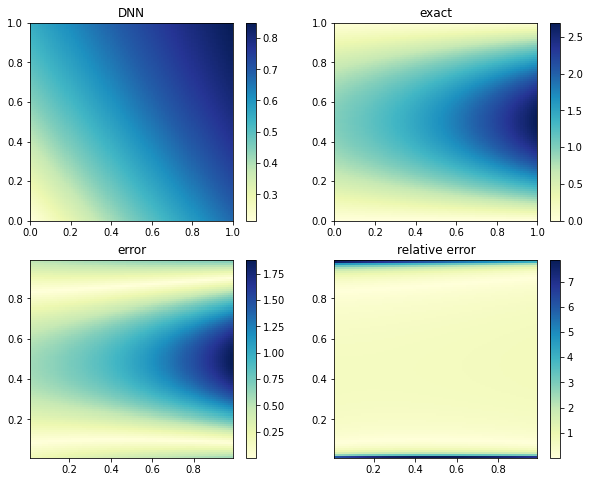

InfNorm: 1.92688328, TwoNorm: 0.76333644, Relative: 0.60607179
Epoch: 501, Time: 50, InteriorLoss: 160.57037354, BoundaryLoss: 0.01743750, GradLoss: 0.05051697, TotalLoss: 160.63833618
Epoch: 601, Time: 60, InteriorLoss: 156.81588745, BoundaryLoss: 0.01723498, GradLoss: 0.04991783, TotalLoss: 156.88304138
Epoch: 701, Time: 69, InteriorLoss: 151.78871155, BoundaryLoss: 0.01713081, GradLoss: 0.04896321, TotalLoss: 151.85481262
Epoch: 801, Time: 79, InteriorLoss: 145.40742493, BoundaryLoss: 0.01704587, GradLoss: 0.04807308, TotalLoss: 145.47254944
Epoch: 901, Time: 89, InteriorLoss: 137.73194885, BoundaryLoss: 0.01686567, GradLoss: 0.04727314, TotalLoss: 137.79608154


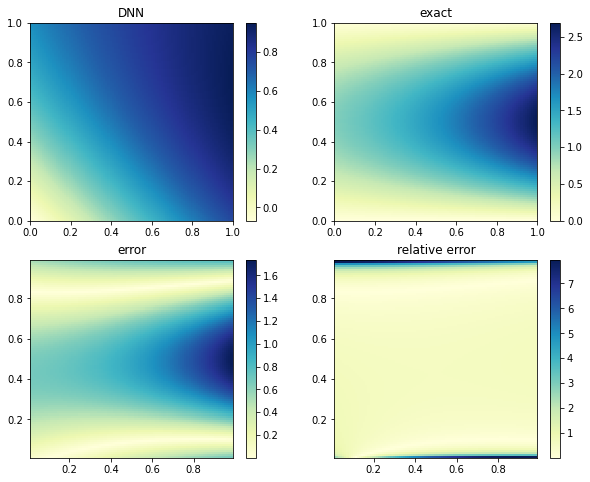

InfNorm: 1.77904755, TwoNorm: 0.71952766, Relative: 0.57128862
Epoch: 1001, Time: 99, InteriorLoss: 128.96754456, BoundaryLoss: 0.01665147, GradLoss: 0.04649459, TotalLoss: 129.03068542
Epoch: 1101, Time: 109, InteriorLoss: 119.46479034, BoundaryLoss: 0.01640627, GradLoss: 0.04572432, TotalLoss: 119.52691650
Epoch: 1201, Time: 119, InteriorLoss: 109.62120819, BoundaryLoss: 0.01613290, GradLoss: 0.04497282, TotalLoss: 109.68231964
Epoch: 1301, Time: 128, InteriorLoss: 99.82565308, BoundaryLoss: 0.01585145, GradLoss: 0.04425125, TotalLoss: 99.88575745
Epoch: 1401, Time: 138, InteriorLoss: 90.42356110, BoundaryLoss: 0.01557676, GradLoss: 0.04356022, TotalLoss: 90.48270416


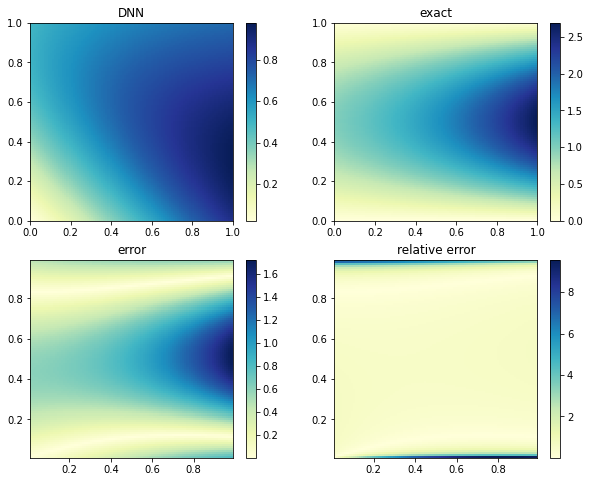

InfNorm: 1.76846124, TwoNorm: 0.68024964, Relative: 0.54010276
Epoch: 1501, Time: 148, InteriorLoss: 81.69161224, BoundaryLoss: 0.01531614, GradLoss: 0.04289417, TotalLoss: 81.74982452
Epoch: 1601, Time: 158, InteriorLoss: 73.82075500, BoundaryLoss: 0.01507982, GradLoss: 0.04225590, TotalLoss: 73.87809753
Epoch: 1701, Time: 168, InteriorLoss: 66.90928650, BoundaryLoss: 0.01489007, GradLoss: 0.04166590, TotalLoss: 66.96584320
Epoch: 1801, Time: 177, InteriorLoss: 60.96707153, BoundaryLoss: 0.01477981, GradLoss: 0.04115421, TotalLoss: 61.02300262
Epoch: 1901, Time: 187, InteriorLoss: 55.93115997, BoundaryLoss: 0.01477761, GradLoss: 0.04073277, TotalLoss: 55.98667145


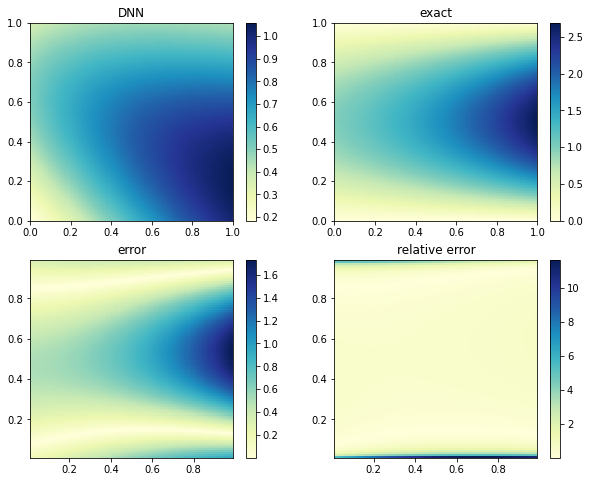

InfNorm: 1.78149303, TwoNorm: 0.65684161, Relative: 0.52151731
Epoch: 2001, Time: 197, InteriorLoss: 51.68892670, BoundaryLoss: 0.01488820, GradLoss: 0.04037314, TotalLoss: 51.74419022
Epoch: 2101, Time: 207, InteriorLoss: 48.10375977, BoundaryLoss: 0.01508272, GradLoss: 0.04001956, TotalLoss: 48.15886307
Epoch: 2201, Time: 217, InteriorLoss: 45.03651810, BoundaryLoss: 0.01529599, GradLoss: 0.03961875, TotalLoss: 45.09143448
Epoch: 2301, Time: 227, InteriorLoss: 42.35492706, BoundaryLoss: 0.01543206, GradLoss: 0.03915222, TotalLoss: 42.40951157
Epoch: 2401, Time: 237, InteriorLoss: 39.90193939, BoundaryLoss: 0.01548928, GradLoss: 0.03877133, TotalLoss: 39.95619965


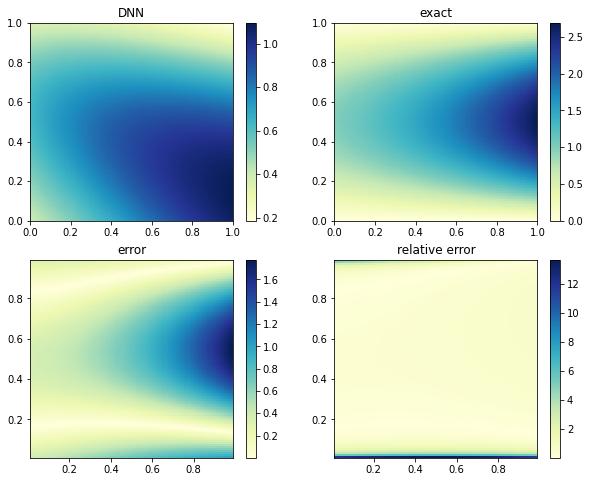

InfNorm: 1.83043469, TwoNorm: 0.65394960, Relative: 0.51922113
Epoch: 2501, Time: 247, InteriorLoss: 37.46427536, BoundaryLoss: 0.01581515, GradLoss: 0.03874168, TotalLoss: 37.51883316
Epoch: 2601, Time: 258, InteriorLoss: 35.06688309, BoundaryLoss: 0.01583198, GradLoss: 0.03859786, TotalLoss: 35.12131119
Epoch: 2701, Time: 267, InteriorLoss: 32.75243378, BoundaryLoss: 0.01517991, GradLoss: 0.03803155, TotalLoss: 32.80564499
Epoch: 2801, Time: 278, InteriorLoss: 30.49576378, BoundaryLoss: 0.01437287, GradLoss: 0.03731681, TotalLoss: 30.54745483
Epoch: 2901, Time: 287, InteriorLoss: 28.28571320, BoundaryLoss: 0.01377458, GradLoss: 0.03667533, TotalLoss: 28.33616257


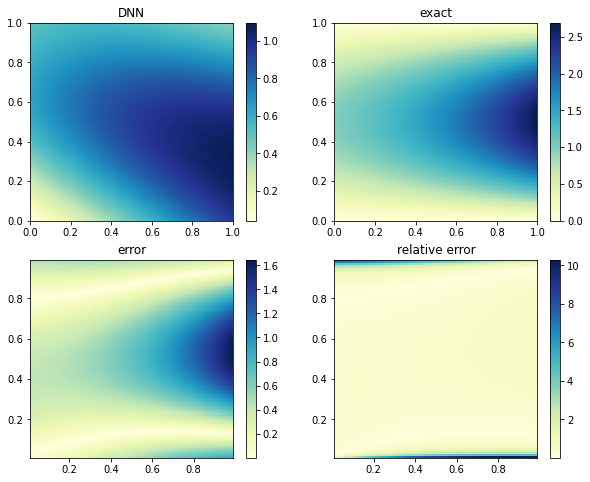

InfNorm: 1.69840224, TwoNorm: 0.60141063, Relative: 0.47750637
Epoch: 3001, Time: 298, InteriorLoss: 26.12395096, BoundaryLoss: 0.01348314, GradLoss: 0.03618400, TotalLoss: 26.17361832
Epoch: 3101, Time: 308, InteriorLoss: 24.02183342, BoundaryLoss: 0.01344429, GradLoss: 0.03583106, TotalLoss: 24.07110977
Epoch: 3201, Time: 318, InteriorLoss: 21.99614906, BoundaryLoss: 0.01357614, GradLoss: 0.03557737, TotalLoss: 22.04530334
Epoch: 3301, Time: 328, InteriorLoss: 20.06594658, BoundaryLoss: 0.01382697, GradLoss: 0.03539041, TotalLoss: 20.11516380
Epoch: 3401, Time: 338, InteriorLoss: 18.25108528, BoundaryLoss: 0.01415514, GradLoss: 0.03523965, TotalLoss: 18.30047989


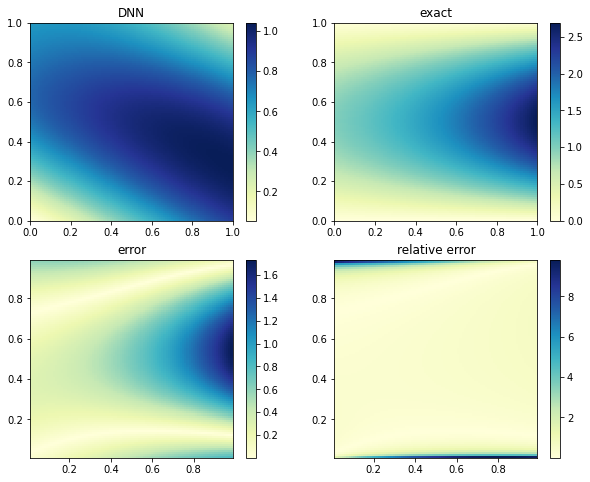

InfNorm: 1.79302343, TwoNorm: 0.60665395, Relative: 0.48166945
Epoch: 3501, Time: 349, InteriorLoss: 16.57035255, BoundaryLoss: 0.01451389, GradLoss: 0.03509431, TotalLoss: 16.61996078
Epoch: 3601, Time: 359, InteriorLoss: 15.03873444, BoundaryLoss: 0.01486188, GradLoss: 0.03493226, TotalLoss: 15.08852863
Epoch: 3701, Time: 368, InteriorLoss: 13.66460037, BoundaryLoss: 0.01517340, GradLoss: 0.03474425, TotalLoss: 13.71451759
Epoch: 3801, Time: 378, InteriorLoss: 12.44843960, BoundaryLoss: 0.01543784, GradLoss: 0.03453056, TotalLoss: 12.49840832
Epoch: 3901, Time: 388, InteriorLoss: 11.38350582, BoundaryLoss: 0.01565403, GradLoss: 0.03429636, TotalLoss: 11.43345547


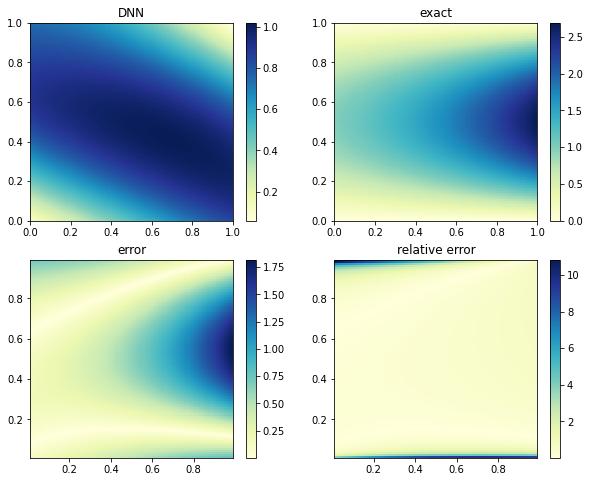

InfNorm: 1.88280166, TwoNorm: 0.62068140, Relative: 0.49280693
Epoch: 4001, Time: 399, InteriorLoss: 10.45772743, BoundaryLoss: 0.01582547, GradLoss: 0.03404947, TotalLoss: 10.50760174
Epoch: 4101, Time: 409, InteriorLoss: 9.65563583, BoundaryLoss: 0.01595697, GradLoss: 0.03380022, TotalLoss: 9.70539284
Epoch: 4201, Time: 418, InteriorLoss: 8.95987129, BoundaryLoss: 0.01605204, GradLoss: 0.03356149, TotalLoss: 9.00948524
Epoch: 4301, Time: 428, InteriorLoss: 8.35210705, BoundaryLoss: 0.01611113, GradLoss: 0.03334815, TotalLoss: 8.40156651
Epoch: 4401, Time: 438, InteriorLoss: 7.81405020, BoundaryLoss: 0.01613419, GradLoss: 0.03317292, TotalLoss: 7.86335754


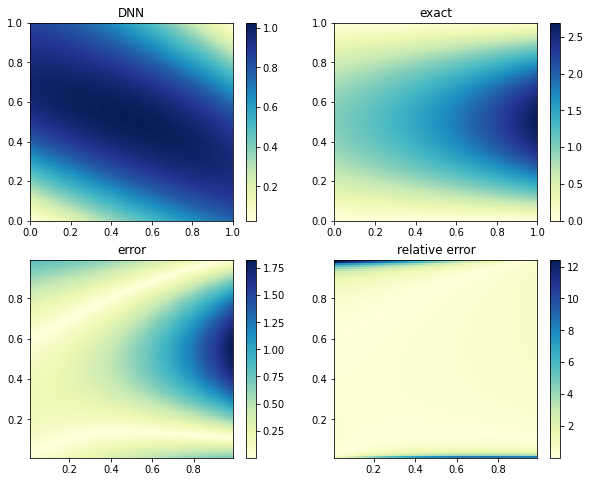

InfNorm: 1.89326013, TwoNorm: 0.62355154, Relative: 0.49508575
Epoch: 4501, Time: 448, InteriorLoss: 7.32918262, BoundaryLoss: 0.01613100, GradLoss: 0.03304012, TotalLoss: 7.37835360


In [ ]:
train_data = generate_uniform_mesh(10)
Loss_list = []
tic = time.time()

for ep in range(1, epochs+1):
  Training(train_data, model, N, M, Loss_list, tic)
  if ep % test_period ==0:
    Testing(x, y, model)

  # Save weight
  if save_weight and (ep==1 or ep % save_period ==0):
    filename = f'DGM_Biharmonic2DWeight_{ep}_{N}_{M}_{lr:.0e}'
    save_path = os.path.join(weight_path, filename + '.h5')
    model.save_weights(save_path)

# Save information

In [ ]:
if save_loss:
  filename = f'DGM_Biharmonic2DWeight_{epochs}_{N}_{M}_{lr:.0e}'
  save_csv(filename+'.csv', Loss_list, ['InteriorLoss', 'BoundaryLoss', 'GradLoss', 'TotalLoss'])